In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
from sklearn.model_selection import train_test_split
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from random import randint
from keras.preprocessing.text import one_hot
import os
import pandas as pd
import re

Using TensorFlow backend.


In [2]:
from stop_words import get_stop_words


In [327]:
epochs = 50
batchSize = 8

max_len_text=200 
max_len_summary=20
checkpoint = "weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
dataset = "dataset/articles.csv"

In [143]:

#df = pd.read_json("dataset.json", encoding='utf-8')
df = pd.read_csv(dataset, encoding='utf-8')

print(df.shape)
print(df.head())
print(df.isnull().sum())

(20346, 6)
                                              titulo  \
0  Lula diz que está 'lascado', mas que ainda tem...   
1  'Decidi ser escrava das mulheres que sofrem', ...   
2  Três reportagens da Folha ganham Prêmio Petrob...   
3  Filme 'Star Wars: Os Últimos Jedi' ganha trail...   
4  CBSS inicia acordos com fintechs e quer 30% do...   

                                               texto        data  categoria  \
0  Com a possibilidade de uma condenação impedir ...  2017-09-10      poder   
1  Para Oumou Sangaré, cantora e ativista malines...  2017-09-10  ilustrada   
2  Três reportagens da Folha foram vencedoras do ...  2017-09-10      poder   
3  A Disney divulgou na noite desta segunda-feira...  2017-09-10  ilustrada   
4  O CBSS, banco da holding Elopar dos sócios Bra...  2017-09-10    mercado   

  subcategoria                                               link  
0          NaN  http://www1.folha.uol.com.br/poder/2017/10/192...  
1          NaN  http://www1.folha.uol.com

In [144]:
df = df.dropna()

In [145]:
df

,titulo,texto,data,categoria,subcategoria,link
43,\n\t\tDa escola ao 1º emprego: como buscar um ...,DA BBC BRASIL O trimestre de maio a julho des...,2017-09-10,sobretudo,carreiras,http://www1.folha.uol.com.br/sobretudo/carreir...
46,"50 anos depois da morte, o Che é apenas uma fo...","Ernesto Rafael Guevara de La Serna, o homem, m...",2017-09-10,colunas,clovisrossi,http://www1.folha.uol.com.br/colunas/clovisros...
59,"Afinal, nosso voto tem preço?",A reforma política aprovada pelo Congresso dei...,2017-09-10,colunas,joao-amoedo,http://www1.folha.uol.com.br/colunas/joao-amoe...
62,"Cientista dá psicodélico para minicérebros, e ...",A batalha de jovens neurocientistas para reabi...,2017-09-10,colunas,marceloleite,http://www1.folha.uol.com.br/colunas/marcelole...
63,Reestruturação da Sabesp deverá ser levada à J...,Associações de empresas de limpeza urbana e re...,2017-09-10,colunas,mercadoaberto,http://www1.folha.uol.com.br/colunas/mercadoab...
65,"Em série sobre Revolução Russa, Mika Lins lê t...",A atriz Mika Lins é a sétima convidada da séri...,2017-09-10,tv,ilustrissima,http://www1.folha.uol.com.br/tv/ilustrissima/2...
71,Preservar passado é um dos grandes desafios do...,"Nas últimas décadas, muitos centros de cidades...",2017-09-10,colunas,claudiobernardes,http://www1.folha.uol.com.br/colunas/claudiobe...
72,Não à Copa sem Lionel Messi,Que o torcedor brasileiro torça contra a ida d...,2017-09-10,colunas,jucakfouri,http://www1.folha.uol.com.br/colunas/jucakfour...
73,UNE processa Lollapalooza por suspeita de burl...,A UNE e outras entidades estudantis entraram c...,2017-09-10,colunas,monicabergamo,http://www1.folha.uol.com.br/colunas/monicaber...
77,"Esquerda pode tomar democratas, que vivem 'cab...","Na manchete do ""New York Times"" de domingo, o ...",2017-09-10,colunas,nelsondesa,http://www1.folha.uol.com.br/colunas/nelsondes...


In [146]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that wo uld", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [147]:
df['titulo'].tolist()

['\n\t\tDa escola ao 1º emprego: como buscar um caminho profissional sem ter (ao menos ainda) um diploma universitário\n\t\t',
 '50 anos depois da morte, o Che é apenas uma foto na camiseta',
 'Afinal, nosso voto tem preço?',
 'Cientista dá psicodélico para minicérebros, e eles gostam',
 'Reestruturação da Sabesp deverá ser levada à Justiça por setor de limpeza',
 'Em série sobre Revolução Russa, Mika Lins lê teses famosas de Lênin',
 'Preservar passado é um dos grandes desafios dos processos de revitalização',
 'Não à Copa sem Lionel Messi',
 'UNE processa Lollapalooza por suspeita de burlar lei da meia entrada',
 "Esquerda pode tomar democratas, que vivem 'cabo-de-guerra', diz 'NYT'",
 'Putin encontra no Oriente Médio maior triunfo diplomático',
 'O candidato da situação',
 'Em queda na pesquisa, Doria pode se atropelar na ambição e fracassar',
 'Reforma em Bruzundanga',
 'Chile ficou seis jogos sem vencer antes de chegar em 3º nas eliminatórias',
 'Sorvete, igual a sexo',
 "Petistas

In [148]:
df['texto'][:10]    

43    DA BBC BRASIL  O trimestre de maio a julho des...
46    Ernesto Rafael Guevara de La Serna, o homem, m...
59    A reforma política aprovada pelo Congresso dei...
62    A batalha de jovens neurocientistas para reabi...
63    Associações de empresas de limpeza urbana e re...
65    A atriz Mika Lins é a sétima convidada da séri...
71    Nas últimas décadas, muitos centros de cidades...
72    Que o torcedor brasileiro torça contra a ida d...
73    A UNE e outras entidades estudantis entraram c...
77    Na manchete do "New York Times" de domingo, o ...
Name: texto, dtype: object

In [149]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
            text = " ".join(new_text)
            text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
            text = re.sub(r'\<a href', ' ', text)
            text = re.sub(r'&amp;', '', text)
            text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
            text = re.sub(r'<br />', ' ', text)
            text = re.sub(r'\'', ' ', text)
            #if remove_stopwords:
            #    text = text.split()
            #    text = [w for w in text if not w in get_stop_words('portuguese')]
            #    print(text)
            #text = " ".join(text)
    return text

In [150]:

cleaned_text = []
for t in df['texto']:
    cleaned_text.append(clean_text(t))

In [151]:

cleaned_summary = []
for t in df['titulo']:
    cleaned_summary.append(clean_text(t))


In [152]:
cleaned_summary

['da escola ao 1º emprego  como buscar um caminho profissional sem ter  ao menos ainda  um diploma universitário',
 '50 anos depois da morte  o che é apenas uma foto na camiseta',
 'afinal  nosso voto tem preço ',
 'cientista dá psicodélico para minicérebros  e eles gostam',
 'reestruturação da sabesp deverá ser levada à justiça por setor de limpeza',
 'em série sobre revolução russa  mika lins lê teses famosas de lênin',
 'preservar passado é um dos grandes desafios dos processos de revitalização',
 'não à copa sem lionel messi',
 'une processa lollapalooza por suspeita de burlar lei da meia entrada',
 'esquerda pode tomar democratas  que vivem  cabo de guerra   diz  nyt ',
 'putin encontra no oriente médio maior triunfo diplomático',
 'o candidato da situação',
 'em queda na pesquisa  doria pode se atropelar na ambição e fracassar',
 'reforma em bruzundanga',
 'chile ficou seis jogos sem vencer antes de chegar em 3º nas eliminatórias',
 'sorvete  igual a sexo',
 'petistas acreditam q

In [153]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

In [154]:
df

,titulo,texto,data,categoria,subcategoria,link,cleaned_text,cleaned_summary
43,\n\t\tDa escola ao 1º emprego: como buscar um ...,DA BBC BRASIL O trimestre de maio a julho des...,2017-09-10,sobretudo,carreiras,http://www1.folha.uol.com.br/sobretudo/carreir...,da bbc brasil o trimestre de maio a julho dest...,da escola ao 1º emprego como buscar um caminh...
46,"50 anos depois da morte, o Che é apenas uma fo...","Ernesto Rafael Guevara de La Serna, o homem, m...",2017-09-10,colunas,clovisrossi,http://www1.folha.uol.com.br/colunas/clovisros...,ernesto rafael guevara de la serna o homem m...,50 anos depois da morte o che é apenas uma fo...
59,"Afinal, nosso voto tem preço?",A reforma política aprovada pelo Congresso dei...,2017-09-10,colunas,joao-amoedo,http://www1.folha.uol.com.br/colunas/joao-amoe...,a reforma política aprovada pelo congresso dei...,afinal nosso voto tem preço
62,"Cientista dá psicodélico para minicérebros, e ...",A batalha de jovens neurocientistas para reabi...,2017-09-10,colunas,marceloleite,http://www1.folha.uol.com.br/colunas/marcelole...,a batalha de jovens neurocientistas para reabi...,cientista dá psicodélico para minicérebros e ...
63,Reestruturação da Sabesp deverá ser levada à J...,Associações de empresas de limpeza urbana e re...,2017-09-10,colunas,mercadoaberto,http://www1.folha.uol.com.br/colunas/mercadoab...,associações de empresas de limpeza urbana e re...,reestruturação da sabesp deverá ser levada à j...
65,"Em série sobre Revolução Russa, Mika Lins lê t...",A atriz Mika Lins é a sétima convidada da séri...,2017-09-10,tv,ilustrissima,http://www1.folha.uol.com.br/tv/ilustrissima/2...,a atriz mika lins é a sétima convidada da séri...,em série sobre revolução russa mika lins lê t...
71,Preservar passado é um dos grandes desafios do...,"Nas últimas décadas, muitos centros de cidades...",2017-09-10,colunas,claudiobernardes,http://www1.folha.uol.com.br/colunas/claudiobe...,nas últimas décadas muitos centros de cidades...,preservar passado é um dos grandes desafios do...
72,Não à Copa sem Lionel Messi,Que o torcedor brasileiro torça contra a ida d...,2017-09-10,colunas,jucakfouri,http://www1.folha.uol.com.br/colunas/jucakfour...,que o torcedor brasileiro torça contra a ida d...,não à copa sem lionel messi
73,UNE processa Lollapalooza por suspeita de burl...,A UNE e outras entidades estudantis entraram c...,2017-09-10,colunas,monicabergamo,http://www1.folha.uol.com.br/colunas/monicaber...,a une e outras entidades estudantis entraram c...,une processa lollapalooza por suspeita de burl...
77,"Esquerda pode tomar democratas, que vivem 'cab...","Na manchete do ""New York Times"" de domingo, o ...",2017-09-10,colunas,nelsondesa,http://www1.folha.uol.com.br/colunas/nelsondes...,na manchete do new york times de domingo o ...,esquerda pode tomar democratas que vivem cab...


In [160]:
for i in range(2):
    print("Review:",df['cleaned_text'].iloc[i])
    print("Summary:",df['cleaned_summary'].iloc[i])
    print("\n")

Review: da bbc brasil o trimestre de maio a julho deste ano foi encerrado com um índice de desemprego na casa de 12 8   o percentual assusta  mas é menor do que os 13 7  apurados no fim do período imediatamente anterior  os dados mostram um quadro preocupante  mas que sugere que o pior da crise pode já ter ficado para trás  só que a situação dos trabalhadores entre 18 e 24 anos é mais complicada do que a da média  segundo a mesma pesquisa do ibge  nada menos do que 28 8  dos jovens nessa faixa etária estavam desocupados ao fim do primeiro trimestre de 2017  esse percentual recorde equivale a 4 503 milhões de pessoas  os trabalhadores mais novos sempre sofrem mais com as crises e o desemprego decorrente  por um lado  eles representam custos menores  e menos produtividade perdida  para as empresas na hora da demissão  de outro  a menor experiência no mercado dificulta a busca por oportunidades  mas é fato também que os empregos que exigem menor qualificação costumam ser os primeiros a su

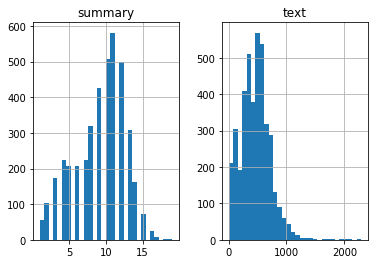

In [161]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

df['cleaned_summary'] = df['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [162]:
df['cleaned_summary'].tolist()

['_START_ da escola ao 1º emprego  como buscar um caminho profissional sem ter  ao menos ainda  um diploma universitário _END_',
 '_START_ 50 anos depois da morte  o che é apenas uma foto na camiseta _END_',
 '_START_ afinal  nosso voto tem preço  _END_',
 '_START_ cientista dá psicodélico para minicérebros  e eles gostam _END_',
 '_START_ reestruturação da sabesp deverá ser levada à justiça por setor de limpeza _END_',
 '_START_ em série sobre revolução russa  mika lins lê teses famosas de lênin _END_',
 '_START_ preservar passado é um dos grandes desafios dos processos de revitalização _END_',
 '_START_ não à copa sem lionel messi _END_',
 '_START_ une processa lollapalooza por suspeita de burlar lei da meia entrada _END_',
 '_START_ esquerda pode tomar democratas  que vivem  cabo de guerra   diz  nyt  _END_',
 '_START_ putin encontra no oriente médio maior triunfo diplomático _END_',
 '_START_ o candidato da situação _END_',
 '_START_ em queda na pesquisa  doria pode se atropelar na

In [163]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df['cleaned_text'],df['cleaned_summary'],test_size=0.2,random_state=0,shuffle=True) 


In [164]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [165]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [166]:
x_tr.shape,y_tr.shape

((3285, 200), (3285, 20))

In [167]:
x_val.shape, y_val.shape

((822, 200), (822, 20))

In [168]:
x_voc_size, y_voc_size

(66740, 7721)

In [169]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [170]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 


In [171]:
#Attention Layer
attn_layer = AttentionLayer(name='attention_weight') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

W1111 15:14:33.352613 11504 ag_logging.py:145] Entity <function rnn at 0x000001BCFB071048> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: The global keyword is not yet supported.
W1111 15:14:33.464610 11504 ag_logging.py:145] Entity <function rnn at 0x000001BCFB071048> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: The global keyword is not yet supported.


In [172]:


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 500)     33370000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [173]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [174]:
if os.path.isfile(checkpoint):
    model.load_weights(checkpoint)

In [175]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint(checkpoint, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [176]:
history=model.fit(
    [x_tr,y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
    epochs=epochs,
    callbacks=[es, mc],
    batch_size=batchSize,
    validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
)

Train on 3285 samples, validate on 822 samples
Epoch 1/50
3280/3285 [============================>.] - ETA: 1s - loss: 3.7627
Epoch 00001: loss improved from inf to 3.76129, saving model to weights-improvement-01-3.7613-bigger.hdf5
3285/3285 [==============================] - 968s 295ms/sample - loss: 3.7613 - val_loss: 2.8325
Epoch 2/50
3280/3285 [============================>.] - ETA: 1s - loss: 3.4879
Epoch 00002: loss improved from 3.76129 to 3.48664, saving model to weights-improvement-02-3.4866-bigger.hdf5
3285/3285 [==============================] - 945s 288ms/sample - loss: 3.4866 - val_loss: 2.8479
Epoch 3/50
3280/3285 [============================>.] - ETA: 1s - loss: 3.3735
Epoch 00003: loss improved from 3.48664 to 3.37185, saving model to weights-improvement-03-3.3719-bigger.hdf5
3285/3285 [==============================] - 951s 289ms/sample - loss: 3.3719 - val_loss: 2.8019
Epoch 4/50
3280/3285 [============================>.] - ETA: 1s - loss: 3.2745
Epoch 00004: loss im

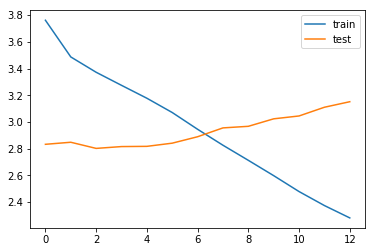

In [177]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [178]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [179]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

W1111 18:42:23.314169 11504 ag_logging.py:145] Entity <function rnn at 0x000001BCFB071048> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: The global keyword is not yet supported.


W1111 18:42:23.790719 11504 ag_logging.py:145] Entity <function rnn at 0x000001BCFB071048> could not be transformed and will be executed as-is. Please report this to the AutgoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: The global keyword is not yet supported.


In [180]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)
        if sampled_token_index == 0:
            return decoded_sentence
            
        sampled_token = reverse_target_word_index[sampled_token_index]
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [181]:
def seq2summary(input_seq):
    newString=''
    #print(target_word_index)
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

In [182]:

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [184]:
#print(reverse_target_word_index)
for i in range(len(x_val)):
  print("Review:",seq2text(x_val[i]))
  print("\n")
  print("\tOriginal summary:",seq2summary(y_val[i]))
  print("\tPredicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: 1982 o milan foi parar na série b por envolvimento de seus jogadores e dirigentes no esquema das apostas na loteria esportiva em 2005 até o goleiro gianluigi buffon admitiu que participava de apostas num caso paralelo de manipulação escalas de arbitragem a juventus foi rebaixada não é só no brasil não é só no futebol não é só com bicheiros há apostas em jogos de tênis da nfl da nba do futebol inglês na itália no rio em são paulo com carimbo oficial dos governos com anúncio de sites em emissoras de televisão a cbf acaba de contratar uma empresa especializada em apostas ilegais para tentar vigiar e evitar que se repitam escândalos como os do passado todo mundo é inocente até que prove o contrário e se houver erro de algum árbitro um frango de um goleiro gol perdido por atacante não pense que foi porque quis errar eu vou lhe avisar goleiro não pode falhar mas muita gente vai comemorar se o zagueiro do seu time entregar o ouro e deixar alguém na cara do gol para acertar os pontos n

	Predicted summary:  o que é ser um esquerda


Review: palavras –mas suas implicações como os de ontem o general tem direito a suas próprias opiniões com a condição de que seja transferido à reserva por que villas bôas limita se a uma advertência protocolar e mesmo ela sob pressão do ministro da defesa o mistério remete aos movimentos ainda desconexos que escapam às telas dos radares numa ponta a crise da lava jato provocada pelo desastroso acordo do mp de janot com os irmãos batista semeia dúvidas sobre o futuro do combate judicial à corrupção sistêmica na outra a corrente periférica de golpistas civis procura estabelecer uma cabeça de ponte nos quarteis por meio da candidatura de jair bolsonaro que se apressou em compartilhar a palestra de mourão villas bôas identificou uma ofensiva em pinça –e equivocadamente preferiu recuar até uma trincheira defensiva o primeiro mourão operava para getúlio vargas em 1937 e para o núcleo golpista do alto comando em 1964 o segundo por ora apenas rep

	Predicted summary:  o que é ser um esquerda


Review: além de acusar ex executivos da odebrecht de desviarem dinheiro do departamento de propinas da empresa rodrigo tacla duran que trabalhou para a empreiteira se esmera em dar detalhes picantes sobre a rotina deles no livro que deve lançar até dezembro diz que era comum por exemplo o consumo de chicletes de viagra antes de certas reuniões o operador a odebrecht reafirma que o sr rodrigo tacla duran jamais prestou serviços jurídicos a qualquer empresa da odebrecht diz o grupo que define tacla como operador financeiro sua participação em atividades ilícitas foi informada pela odebrecht às autoridades no processo de colaboração com a justiça leia a coluna completa aqui 


	Original summary: advogado uso de de em reuniões da odebrecht 
	Predicted summary:  o que é ser de esquerda


Review: urna o jogo muda nenhuma decisão jurídica poderá alegar isenção política dado que terá impacto político direto al capone foi condenado por sonegação de

	Predicted summary:  o que é ser um empresa de carros sobre um futuro da casa


Review: ele deixa o cargo interinamente se condenado eleição indireta avisa o jornal — o processo todo poderia levar sete meses ou mais embraer não o wall street journal destaca que concorrentes de china rússia e canadá ameaçam o duopólio de boeing e o presidente da qatar airways diz não ter problema nenhum de comprar aviões russos ou chineses mas a boeing já começou a agir na justiça contra os novatos observa o jornal — enquanto isso a embraer do brasil evita encarar boeing e e se prende a aviões menores missão de paz sobre a venezuela o ft passa ao largo do plebiscito e noticia que o presidente da colômbia juan manuel santos viajou a cuba para convencer o país a apoiar um esforço diplomático regional para conter a crise venezuelana a iniciativa seria apoiada por argentina e méxico nada de brasil acostumados à morte em artigo no nyt com foto de duas mulheres mortas em operação da polícia no rio acima a vid

	Predicted summary:  o que é ser um esquerda


Review: de entre 30 de junho e 2 de julho a disputa entre o boi garantido e o será exibida para até 132 milhões de pessoas em 26 estados e no distrito federal lista negra uma proposta na câmara municipal de são paulo quer proibir a venda de a menores de idade o vereador gilberto nascimento psc está chamando uma audiência pública para discutir a proibição som ao redor o rapper as cantoras e manu e a dupla formada por ana clara caetano e vitória falcão fizeram show na festa de lançamento da tim music na quarta 21 no villaggio jk o sambista e o presidente da universal music paulo lima estavam na plateia curto circuito elza soares é homenageada em bate papo nesta sexta 23 às 20h no auditório ibirapuera as inscrições para o evento já estão encerradas a banda cachorro grande faz shows para gravar disco ao vivo nesta sexta 23 e sábado 24 no centro cultural rio verde rincon sapiência faz show nesta sexta no mis às 21h30 laís bodanzky e maria ribei

	Predicted summary:  o que é ser um empresa de carros sobre um futuro da casa


Review: chegou em curitiba se ele não sabe de nada nem onde fica curitiba rarará e os manifestantes pró lula o deve tá vomitando com o cheiro de pobre e adoro aquelas pessoas que ficam na rua com o cartaz lula na cadeia rarará e o lula não vai para a cela comum porque ele é doutor honoris causa doutor honoris causa própria e tenho certeza que ele disse que não conhece o e que o instituto lula se chama instituto amigo do lula rarará lula x moro dr em curitiba discutindo a relação amor e ódio encruados eu acho que eles já estão ficando mais um depoimento e eles ficam rarará uma coisa assim e ufa o moro não estava de camisa preta e gravata vermelha rarará é mole o moro não é mole e todo mundo sabe que o santander pra trás cancelou expo lgbt e o mbl virou um grupo paramilitar virou milícia invade sala de aula exposição lgbt e daqui a pouco estão invadindo teatro e espancando os atores milícia milícia da burrice

	Predicted summary:  o que é ser de esquerda


Review: caricatura oferecendo a recompensa da identificação é uma versão mais rasa e pasteurizada mas não tão distinta em objetivo de um seinfeld ou um breaking bad que nos fazem torcer em momentos e rir das nossas a isso some se as pinceladas da grande tv aberta e suas comédias de algumas piadas muito bem escritas visando um público específico e a invertida na perene cultura do perdedor x vencedor que vigora nos eua já young não diz a que vem é uma série sobre um anos incríveis ou um in the explorando aquela sensação de desconforto é uma série família típica numa de modern family é uma viagem oitentista com referências de época —o jovem aos 9 anos cresceu nos anos 80 início dos na cola de stranger things não sabemos o que fica do primeiro episódio com um elenco de apoio anódino e um texto idem é a fofura de e a perspicácia de jordan acompanhada de uma narração estranhamente contida do próprio jimmy parsons o adulto em e de um roteiro preg

	Predicted summary:  o que é ser um empresa de futebol sobre o que não foi fazer e ele


Review: títulos em busca de liquidez morava numa espécie de distrito financeiro de ur um bairro que reunia comerciantes gestores de fundos e investidores na esquina da sua rua arqueólogos encontraram placas de argila com registros do numa atividade que lembra o 3g capital de jorge paulo lemann reunia dinheiro de investidores para comprar participações de empresas e para financiar expedições comerciais uma das empreitadas de reuniu investimentos de 51 moradores de ur o dinheiro foi aplicado numa expedição marítima pelo golfo pérsico até reino no atual território do qatar para trocar prata e fabricados em ur por cobre pedras preciosas e temperos o contrato de com os investidores que até hoje por ser gravado em argila lembra os fundos de private equity com responsabilidade limitada dos cotistas se a expedição desse prejuízo os investidores se até o limite do que tinham investido se desse lucro ele ser

	Predicted summary:  o que é ser de quem é um país em um ano de amazônia


Review: ser governador do rio esta semana o presidente da alerj jorge picciani disse que ele será o candidato do pmdb alguém duvida que ele ganhe se nada lhe acontecer judicialmente até lá talvez você não se lembre mas aparecem nas fotos o então ministro dos esportes orlando silva que deixou o cargo adivinhe acusado de participar de um esquema de desvio de dinheiro público do programa segundo tempo uma ação do governo federal que deveria promover o esporte em comunidades de baixa renda esse pessoal não tira só o leitinho das crianças está lá também joão havelange morto em agosto de 2016 bem no meio da rio 2016 o todo poderoso da fifa estava afastado da vida pública desde 2013 em meio a acusações de ter recebido propina pela venda dos direitos de mídia em torneios de futebol e também para que a agência de marketing esportivo isl tivesse exclusividade de contratos com a entidade agora foi a vez de nuzman o homem m

	Predicted summary:  o que é ser de esquerda


Review: ampliar as opções de formação de profissionais para o setor de reparos de automóveis a ideia que começou com apenas uma sala em campinas interior de são paulo se expandiu para outras partes do estado e do país hoje a escola já conta com seis unidades e até o fim de 2017 a empresa planeja inaugurar mais 20 com foco no sul e sudeste conta que 70 dos alunos são jovens em busca do primeiro emprego e 30 são profissionais que já atuam na área e estão procurando alguma especialização os carros evoluíram e o número de marcas e modelos aumentou nem todos os profissionais conseguiram acompanhar diz um curso completo de formação básica para mecânico de carros sai por r 2 280 o investimento inicial de acordo com a empresária foi de r 40 mil ao longo de seis anos cerca de r 2 milhões já foram investidos no negócio que foi para se tornar franquia em 2015 uma unidade da escola no modelo de franquia pode ser adquirida por um valor a partir de r 20

	Predicted summary:  o que é ser um esquerda


Review: iguais feitas exclusivamente com base em poucas e confusas informações divulgadas pela polícia federal não nenhum órgão de imprensa que tenha levantado inconsistências ou ao menos tentado relativizar as acusações apresentadas esse comportamento não é exclusivo desse caso tem sido rotineiro diante de tantas investigações questionei o secretário de redação vinicius mota sobre a forma como o jornal vem abordando investigações recentes a folha se preocupa como está em seus documentos públicos em não ser veículo involuntário de injustiças contra pessoas ou empresas para isso se compromete com protocolos como a necessidade de ouvir e destacar o outro lado e a correção explícita de erros como foi feito nesse caso respondeu o ambiente punitivo nascido da espetacularização da ação policial e dos procedimentos judiciais tem reflexos e responsabilidade da imprensa jornais e jornalistas não podem aderir a ondas nem de condenação de acusados ne

	Predicted summary:  o que é ser um esquerda


Review: um botão libertador como disse uma atriz de 63 anos minha vida mudou completamente quando descobri o botão do f se eu não fico dizendo f se para todo mundo f se para o que os outros pensam é muito mais uma atitude de não me preocupar com a opinião dos outros vão achar que eu sou uma velha ridícula porque vou à praia de biquíni f se vão pensar que sou uma velha sem noção porque gosto de dar beijo na boca f se vão dizer que sou uma velha porque ainda uso f se esse f se interno é libertador elas aprenderam a rir e brincar muito mais dentre as mulheres mais jovens que pesquisei 60 invejam a capacidade masculina de rir de qualquer bobagem perguntei por que vocês não riem mais elas responderam porque eu não tenho tempo ou tenho medo do que os outros vão pensar a atriz concluiu depois dos 60 resolvi não me levar tão a sério passei a rir muito mais de mim mesma dou tantas gargalhadas que sempre faço xixi na calça agradeço a deus todos os d

	Predicted summary:  o que é ser um esquerda


Review: o poeta repete se como uma pintura dele mesmo assim como muitos quadros de peter os poemas de tratam de coisas não são difíceis de entender ao mesmo tempo cada realidade representada pelo simples fato de se ter duplicado ganha um poder a realidade não é simplesmente copiada é como se a ressurreição dos mortos talvez seja um dos temas chave do livro mais importante de traduzido para o português por paulo companhia das letras 2011 os mortos são os antepassados africanos deste poeta nascido na ilha de santa lúcia nas —mas também os heróis da ilíada que ganham nova existência como pescadores ou motoristas de vans naquele destino turístico de luxo um dos grandes méritos de está em recorrer à história de heitor de aquiles e de helena de troia sem ceder às facilidades —em que nós brasileiros somos da paródia e da avacalhação colonialismo floresta pobreza oceano turismo bruxaria e tradição clássica se organizam numa obra longa e complexa c

	Predicted summary:  o que é ser de esquerda


Review: você deixou o emprego diz em seu estudo mais recente funcionários que disseram sentir níveis mais altos de insegurança no trabalho tiveram depressão até três anos mais tarde diz ela passar por altos níveis de insegurança no trabalho era a cereja no bolo para ficar depressivo mesmo se alguns tiverem desempenho melhor com um pouco de incerteza aqueles que se sentem inseguros no trabalho estão em desvantagem diz a ideia de que algum nível de insegurança pode fazer os funcionários mais produtivos é um conceito falso garante ela há uma relação entre insegurança com o trabalho níveis mais baixos de performance e de comportamento e mais comportamentos de bullying e rotatividade real afirma para os funcionários que querem se sentir mais confortáveis no emprego sugere olhar para gerentes e firmas que focam na justiça e transparência o que pode ajudá lo a trabalhar melhor durante épocas de incerteza não importa qual seja seu setor você ficar

	Predicted summary:  o que é ser um joesley


Review: que a destituição de assad seja condição prévia para tudo com ou sem o ditador sírio macron não quer mais um estado fracassado acrescentando — a frança errou ao fazer a guerra na líbia mais guerra enquanto isso no washington post funcionários do governo trump diziam que confirmada a derrota do estado islâmico em raqqa o próximo estágio da guerra será uma luta que levará ao conflito direto com o governo sírio e as forças que reivindicam o controle de um vasto deserto no leste do país já começou críticos de mídia questionam a cobertura americana sobre a síria que publica que os eua estão sendo sugados para mais guerra atlantic ou numa guerra maior new york times em editorial enquanto suas forças na realidade começam a derrubar aeronaves sírias e e já mataram 300 civis em raqqa como afirmou ao mesmo nyt o brasileiro paulo sérgio pinheiro que chefia comissão da onu para a síria vendedor a agência associated press revelou que o correspon

	Predicted summary:  doria é a usp de doria mas a paris


Review: em que as tarifas serão consideradas entre intermediárias e de ponta portanto mais caras um profissional solteiro com horário flexível que saia à noite e às vezes trabalhe até mais tarde talvez tenha muitas vantagens em aderir a esta forma de de qualquer forma temos de aprender a economizar água e energia elétrica são dois insumos que ficarão mais caros ao longo dos anos em função da demanda e do clima as novas matrizes energéticas deverão melhorar este quadro já há um crescimento expressivo da energia eólica simbolizada pelas turbinas cada vez mais visíveis no litoral brasileiro em 2018 estima se que o brasil o top 20 da energia solar mundial ou seja que esteja entre os 20 maiores produtores mundiais deste tipo de energia como sol é o que não falta por aqui as perspectivas são positivas ainda assim não devemos deixar aparelhos eletrônicos na função stand by enquanto estivermos dormindo também não há motivo para iluminar

	Predicted summary:  o que é ser um esquerda


Review: de são paulo sinais um jeito de saber que é hora de trocar o sistema de freio por 15 componentes como lona tambor cilindro de roda cilindro mestre servo freio pinça disco pastilha e fluído de é ficar de olho no painel eletrônico do carro uma luz se acende caso haja problemas mais urgentes ruídos vibração no volante ou ruídos no pedal são outros indícios de que o sistema não vai bem a cada seis meses é importante avaliar o fluído de freio que permite que todo o sistema funcione se estiver vencido deve ser trocado pastilhas checar a condição da pastilha de freio que ao entrar em contato com o disco de freio faz o carro parar também ajuda ela tem uma marca que indica o limite de desgaste cuidados não existe um prazo definido para a substituição dos componentes do sistema de freios o desgaste das peças depende do uso do veículo por isso o ideal é fazer manutenção preventiva fonte fábio gerente de vendas da 


	Original summary: saiba c

	Predicted summary:  o que é ser de esquerda


Review: usuário baseando se em um banco de dados com casos de empresas que já passaram por situações semelhantes há muito conteúdo sobre empreendedorismo na internet mas quase nada proporciona interação diz o administrador daniel pereira 36 ceo da clara lançada em janeiro deste ano ele explica que para conversar com a mentora o empreendedor fornece seus dados em que estágio se encontra e o seguimento no qual atua também informa quais são seus maiores desafios a finanças ou gestão por exemplo a partir daí a clara sugere soluções e responde dúvidas há ainda um fórum de debate que põe em contato todos os empreendedores inscritos pereira afirma que hoje já são mais de 7 000 o valor da assinatura é r 29 90 com mês inicial grátis a maioria dos empreendedores não tem o background de administração a clara veio para preencher uma lacuna e somar aos outros tipos de apoio como blogs e revistas diz pereira veja outras edições do sigam me os bons site 

	Predicted summary:  o que é ser de esquerda


Review: acomodar o abismo entre o real e o ideal entre o que existe e o que deveria existir nos últimos meses tenho recebido vários e mails de indignação e repulsa motivo minhas condenações de trump ou le pen como é possível perguntam os meus ex leitores ser conservador e não tolerar essas duas tristes figuras alguns com ironia exigem a devolução do dinheiro que pagaram pelo meu livro as ideias conservadoras curiosamente nenhum deles leu o subtítulo explicadas a revolucionários e reacionários não há nada de conservador em trump ou le pen ambos são exemplos vivos da mente ambos defendem um passado de proteção econômica fechamento nacional e isolamento internacional que nunca existiu como modelo de perfeição são reacionários porque incapazes de pensar os problemas do presente sem recorrer ao era uma vez que é típico de crianças não de adultos o conservadorismo é uma ideologia de imperfeição humana não de arrogância é uma ideologia que procur

	Predicted summary:  o que é ser de esquerda


Review: do mundo aquele das mãos pensas o que pensas de pensas é claro que ninguém está seguro ninguém mesmo constato mais uma vez ao ler a nova introdução que caetano veloso escreveu para a edição comemorativa do 20º aniversário daquele seu opa quem sabe tão interessante quanto barroco verdade tropical diz ele foi escrito na flor dos meus 54 anos quando a memória para o vocabulário era rápida e precisa hoje penso que deveria comprar um dicionário ou achar um online mas me esqueço de fazer uma coisa ou outra fiquei assustado ao descobrir que também para o compositor baiano tão hábil em sua língua na língua de luís de camões as palavras andam fazendo doce na flor dos meus 55 até hoje nunca tinha me ocorrido a ideia pensando de que a idade pudesse ser mais um fator de dureza nesse jogo confesso que tais pensamentos me deixaram meio que já foi tempos atrás uma das palavras que mais me davam alegria numa frontal contradição entre sentido e for

	Predicted summary:  o que é ser de esquerda


Review: a independência a pesquisa mais recente feita em julho e encomendada pelo próprio governo regional que convocou o plebiscito mostrou 41 a favor da independência e 49 contra em votação igualmente ilegal em 2014 compareceram apenas 2 2 milhões de eleitores de um total potencial de 5 4 milhões no dia 10 el país publicou pesquisa em que 56 disseram considerar o plebiscito ilegal entre os jovens de 18 a 34 anos a porcentagem subia a 63 a pesquisa mostrava que 56 defendiam buscar uma saída negociada para a crise entre o governo central e o da catalunha seria de fato o ideal mas o incêndio nesta quarta feira criou tal instabilidade que dá razão à opinião do escritor em texto para el país a gravidade extrema dos fatos protagonizados pelo –quer dizer pela é de uma magnitude tão catastrófica que quase impede pensar no que pode ser o dia seguinte a institucional a incerteza jurídica o temor imediato à instabilidade a perda de coesão social e 

	Predicted summary:  o que é ser um escola de quem é um país com o mundo


Review: os ministros eliseu padilha casa civil moreira franco secretaria geral e antônio imbassahy secretaria de governo e o senador romero jucá pmdb rr gravaram vídeos na madrugada desta quinta feira 18 em defesa do presidente temer os aliados do presidente saem em ajuda do peemedebista após gravação feita por um dos donos do grupo j f proprietário do frigorífico jbs mostrar o presidente falando sobre a compra do silêncio do ex deputado federal eduardo cunha pmdb rj em um dos vídeos o senador romero jucá pede que as delações e gravações sejam públicas imediatamente temer do empresário joesley batista da jbs que ele estava dando a eduardo cunha e lúcio funaro um dos operadores da operação lava jato uma mesada na prisão para que ficassem em silêncio romero jucá romero jucá eliseu padilha eliseu padilha antônio imbassahy antonio imbassahy moreira franco moreira franco 


	Original summary: ministros e parlamentare

	Predicted summary:  o que é ser um quem não é melhor de um país e sempre


Review: e uma patrulha da pm apareceu mas não pôde com os criminosos armados com fuzis saiu atrás de reforços que só chegaram horas depois o roubo foi uma demonstração de força do tráfico que está buscando expandir sua fonte de lucro por meio da cobrança de uma taxa de segurança dos comerciantes tática mais associada às milícias como os lojistas se a pagar os traficantes da providência mostraram na prática que sem acordo com eles não há segurança para a região nem mesmo proteção privada é solução como mostra o episódio mais incrível dessa história revelado pelo site g1 o segurança de uma das lojas chegou para trabalhar na madrugada e topou com o saque generalizado negro armado sozinho contra um bonde de dezenas numa rua escura não teve dúvida ou se misturava à turba ou poderia ser confundido com um policial assim o fez passando por ladrão para sobreviver como contou a seu patrão traficantes de um morro pacifica

	Predicted summary:  o que é um amazônia


Review: da fei onde 20 dos 7 500 alunos são de outras cidades um deles é daniel 20 de 170 quilômetros da capital que desembarcou há um ano para estudar engenharia de produção na fei trocou a casa dos pais por uma república no bairro assunção a menos de 2 quilômetros do campus onde compartilha a rotina de estudo e festa com o irmão e outros oito colegas juntos eles dividem o aluguel de r 4 500 da casa com três quartos sala de jogos churrasqueira e terraço com as despesas incluídas a conta fica no máximo em r 600 por mês para cada a cada semestre eles organizam uma festa no local para 300 convidados com entrada a r 40 a vizinhança sabe que é uma república não temos problemas nossas festas são realizadas no horário permitido das 10h às 22h morador da mesma república desde 2013 após sair do tatuapé zona leste de são paulo lucas 25 não quis deixar a casa após se formar em engenharia no ano passado na fei gosto de são bernardo e o valor que pago aqu

	Predicted summary:  o que é ser um esquerda


Review: três dias depois de ouvir o depoimento de lula no dia 10 o juiz sergio moro vai debater o papel do poder judiciário com o ex ministro e advogado josé eduardo cardozo os dois vão falar na mesma mesa no dia 13 de maio no brazil forum uk na london school of economics and political science em londres o ministro do stj ricardo villas bôas cueva e o advogado josé alexandre buaiz sócio do escritório pinheiro neto participam da mesma discussão leia a coluna completa aqui 


	Original summary: moro e ex ministro cardozo farão debate em londres 
	Predicted summary:  vídeo explica a usp dos tensão na 2018


Review: r 1 5 milhão mas dinheiro não basta para garantir um quinhão de ar puro de início apenas convidados poderão comprar as casas queremos pessoas que pensem como nós diz ralston por isso os interessados devem seguir regras como não levantar muros e contratar mão de obra local na segunda fase planejada para 2018 o casal oferecerá casas 

	Predicted summary:  o que é ser de esquerda


Review: técnico que também é a minha de que arthur se torne quem sabe já na copa o meio campista que falta à seleção paulinho é ótimo no desarme e na chegada ao ataque para fazer gols e casemiro é excelente para proteger a defesa e dar o passe inicial da jogada ofensiva arthur poderá ser a ligação entre a saída de bola e a chegada à área adversária sobraria renato augusto que caiu de produção outra alternativa é trocar um volante renato augusto por um meia de ligação pelo centro coutinho tite convoca pela qualidade técnica e muito pelo posicionamento tático por ser um armador diego sem merecer foi chamado para ser o reserva de coutinho caso ele jogue pelo meio já que luan é mais um segundo atacante já tardelli por ser um atacante pela esquerda que entra pelo centro para finalizar foi chamado para ser o reserva do reserva de neymar já que a primeira opção seria coutinho entrando william pela direita coutinho se não for o titular pela direit

	Predicted summary:  o que é ser um aviso


Review: de são paulo o blog homens da casa apesar do nome não é voltado só para o público masculino –nem dá dicas sobre como consertar o encanamento da cozinha ideias de decoração universais diz o publicitário eduardo mendes fundador da página o objetivo é ensinar as pessoas a deixar a casa do jeito que querem com tutoriais de faça você mesmo as criações compartilhadas são todas feitas na casa de mendes morador de em minas gerais ele conta que seu estilo preferido é o industrial e que costuma reaproveitar materiais para inventar novos móveis e objetos decorativos por não ser formado na área de arquitetura ou decoração compartilho dicas com uma visão menos teórica e mais prática com meus leitores explica o publicitário divide seu tempo entre o blog e um estúdio que realiza projetos de decoração on line sou o diretor criativo mas quem cuida da parte técnica são os arquitetos e designers que trabalham comigo diz ele que cobra cerca de r 110 por 

	Predicted summary:  o que é ser de esquerda


Review: o estado coordena as decisões de investimento concedendo subsídios e proteções de outro o brasil novo da agenda republicana com ênfase na melhora do ambiente de negócios na concorrência e na política social não se trata de agenda fácil e são frequentes os retrocessos as regras sobre diversos gastos públicos obrigatórios determinados por lei como a previdência resultam no seu crescimento acima da renda nacional esses gastos já somam 105 da receita líquida do governo federal o dinheiro começa a acabar comprometendo políticas essenciais como em ciência e tecnologia a constituição e a boa gestão rejeitam o aumento da dívida para financiar as despesas correntes na ausência de reformas que reduzam os gastos obrigatórios o resultado será a paralisia do governo e a volta da inflação para equilibrar as contas públicas não há saída fora da política superar as dificuldades requer negociar perdas assim como reformas que permitam ganhos de prod

	Predicted summary:  o que é ser de esquerda


Review: 17 projetados no início do ano em fevereiro pela primeira vez nenhuma das fábricas atingiu sua meta a área de ferramentas foi uma das maiores responsáveis pela desaceleração recuou 30 no período a empresa também concentra esforços em ampliar a venda de panelas de inox segmento que responde por 10 da receita a fábrica dedicada ao produto com capacidade para produzir 400 mil itens por mês tem ociosidade de 30 a crise brasileira é de confiança embora hoje a economia esteja se descolando da política temos de trabalhar e falar menos de lava jato o importante agora é resolver o desemprego o grupo também reduziu sua velocidade de investimentos em 25 neste ano em geral o nível de aportes é de 10 da receita anual a previsão porém é fechar este ano com alta de 9 5 e retomar o ritmo de expansão e de investimentos em 2018 nunca paramos de investir o mercado é cíclico queremos estar prontos quando a crise passar r 4 75 bilhões foi a receita tot

	Predicted summary:  o que é ser de quem é um país em um ano de andrade


Review: que mantinha em casa o equivalente a meio milhão de reais em moedas estrangeiras referentes a sobras de viagens ex atleta olímpico nuzman só chegou ao ouro em julho de 2014 data em que admitiu ter comprado 16 quilos do metal em barras as em um cofre suíço atribuiu o valor de r 1 5 milhão às peças adquiridas com recursos próprios à receita o ministério público apreendeu uma chave e cartões da empresa suíça que disponibiliza cofres para a guarda de bens é a mesma empresa utilizada por sérgio cabral para ocultar diamantes ao contrário de bancos essas empresas não são obrigadas a questionar ou informar a origem dos recursos e bens que mantêm nos cofres as investigações se agora para suspeita de que nuzman tenha recebido dinheiro em contratos estabelecidos pelo cob com um hotel uma empresa de ônibus e uma empresa de marketing em 2009 nuzman estava presente no restaurante do chefe alain ducasse em mônaco quando

	Predicted summary:  o que é ser de quem é um melhor de melhor que nos eua de amazônia


Review: economista borges da lca consultoria calcula um deficit de r 155 bilhões neste ano portanto abaixo da meta de r 159 bilhões sem contar com um centavo do programa de parcelamento de tributos o refis se tornou muito mais importante para o governo negociar apoio no congresso do que para a arrecadação evidentemente qualquer folga orçamentária em um país desigual e carente de infraestrutura como o brasil seria mais bem utilizada em outros fins do que na compra de apoio parlamentar para manter temer no poder além disso a política miúda esconde um debate muito mais importante sobre o refis sucessivos tributários desde o início deste século um refis a cada dois anos— vêm incentivando as empresas a não acertar suas dívidas com o governo por outro lado as pesadas penalidades impostas pela receita transformam débitos em atraso em contas impagáveis se não houver algum alívio matéria desta folha mostrou

	Predicted summary:  vídeo explica a tensão e pode mudar a eua com o futuro


Review: de setembro dando boas vindas à primavera nesta semana lamentavelmente um morador de rua em são paulo e outro em curitiba morreram sob suspeita de não terem ao frio com a chance de a baixa temperatura permanecer nos próximos dois meses cuidados especiais são necessários principalmente em relação ao que evitar nos dias mais frios portadores de problemas nas artérias coronárias devem afastar a possibilidade de sofrer um choque térmico que poderá ser fatal depois de permanecer em ambiente interno bem aquecido esses pacientes devem evitar passar para áreas de baixa temperatura a entrada rápida em um setor muito frio saindo de área bem aquecida pode provocar constrição das coronárias resultando em dificuldade na circulação sanguínea e às vezes até em um infarto fulminante outro risco é o co de carbono resultante de carvão em brasa ou da queima da madeira em ambientes fechados o co é produzido pela combustã

	Predicted summary:  o que é um ano de trabalho


Review: bons custos de compra e de manutenção a tendência é que esse compartilhamento ajude a reduzir custos de reparo as plataformas modulares permitem também a construção de carros híbridos ou movidos a eletricidade na mesma linha em que são feitos os modelos a combustão isso permitirá a redução dos custos de veículos não poluentes que tendem a ganhar escala muitas cidades que restringem a circulação de carros abrem suas ruas a modelos que não soltam fumaça no brasil esse tipo de construção de automóveis ainda é restrito a poucos modelos como o golf e o audi a3 produzidos em são josé dos pinhais pr a indústria nacional ainda engatinha nesse aspecto contudo é preciso olhar adiante o crescimento das exportações é limitado em parte pela falta de produtos que possam ir além das fronteiras da américa latina as exceções são os carros de marcas premium produzidos por aqui mas a maior parte das peças de modelos bmw mercedes e land rover vem d

	Predicted summary:  o que é ser um ueba zona de reforma e são paulo


Review: a remuneração nas empresas recuou para os mesmos patamares observados em 2011 e 2012 segundo as consultorias hays e rh plus a queda considera tanto a redução do ganho com renda variável atrelada a resultados e naturalmente menor em momentos de recessão quanto com o da renda fixa diz caroline cadorin diretora da hays muitas companhias fizeram desligamentos e passaram a ter tanto funcionários com salários menores e escopo de atuação maior como menos profissionais em cargos mais elevados na hierarquia das 300 empresas entrevistadas que atuam no brasil 60 dizem que foi necessário cortar vagas de trabalho em 2016 o número é maior que o observado na pesquisa do ano passado de 52 um número significativo de companhias no entanto aceitou pagar mais do que o esperado por profissionais de outras empresas foram 33 neste ano contra 27 no levantamento anterior no alvo do rh cargos que deverão ter vagas abertas segundo emp

	Predicted summary:  o que é ser um quem não é melhor de um país


Review: renda é do conjunto da sociedade para os ricos não dos ricos para os pobres derrubada a propaganda de que a desigualdade se reduziu nos anos do pt fica o desafio de enfrentá la o que evidentemente não está na agenda do atual governo como é óbvio trata se de problema de tremenda complexidade mas há pelo menos um ponto essencial que jamais é enfrentado a tributação o trabalho da fundação joão mostra que as famílias pobres gastam 32 de sua renda em pagamento de impostos enquanto as mais ricas gastam 21 é uma decorrência inexorável do sistema tributário brasileiro fortemente baseado em impostos indiretos que incidem sobre o consumo é muito baixa a tributação sobre propriedades heranças e patrimônio em geral diz o texto completa o imposto de renda por sua vez penaliza fortemente a classe média pois as rendas recebidas sob a forma de distribuição de lucros e dividendos tipicamente apropriadas pelos mais ricos estão is

	Predicted summary:  o que é ser de esquerda


Review: —como se por ter feito os papéis título em frankenstein 1931 e a múmia 1932 ele fosse um símbolo do horror mas olhe é uma injustiça boris karloff apenas viveu aqueles papéis e os dois filmes ficaram entre os maiores do gênero na vida real karloff 1887 1969 foi um dos homens mais queridos de hollywood ele era na verdade inglês com formação teatral fã de joseph conrad e amigo de escritores e dramaturgos devia ser um grande ator já que conhecido por sua suavidade e ternura para com os amigos os filmes só o queriam para viver loucos drogados carrascos sádicos e até de túmulos karloff trabalhava em hollywood mas mantinha um apartamento em nova york no edifício dakota onde se passa o bebê de e onde john lennon seria morto em 1980 no karloff deixava doces e balas à porta dos apartamentos do dakota onde moravam crianças as e não queria que tivessem medo dele para elas gravou infantis e trabalhou em alice no país das maravilhas e peter pan 

	Predicted summary:  o que é ser um esquerda


Review: de matrizes africanas e de espíritas mas a maioria reclamava da ausência de ateístas a onda de emails foi estimulada por uma entidade denominada atea associação brasileira de ateus e agnósticos cujo presidente exortou associados e seguidores a se queixarem grande parte das mensagens tinha trechos idênticos e argumentava que o debate sem um ateu seria um monólogo segundo o censo 2010 do ibge 64 6 dos brasileiros se dizem católicos 22 2 evangélicos 2 espíritas 3 são adeptos de umbanda e ou candomblé e as outras religiões somadas atingem 2 7 os que dizem não ter religião são 8 para a editora de treinamento e seminários suzana singer não estará em discussão o estado laico não há razão para chamar um representante ateu para garantir um debate dinâmico limitamos o número de palestrantes a quatro denominações religiosas sem a intenção de refletir a distribuição de credos na população brasileira não acho que a organização de um debate deva

	Predicted summary:  o que é ser de esquerda


Review: o bom senso também se esvaiu como os protestos de então se hoje o presidente da cbf está obrigado a viver dentro das fronteiras brasileiras assim como o do cob e o presidente da república é um nada duas vezes denunciado pela justiça com um ministério que mais parece uma quadrilha mas as ruas estão mudas marco polo del nero carlos arthur nuzman michel miguel elias temer lulia são três fantasmas a assombrar nosso cenário alvos do escárnio e da chacota mundiais casagrande criticou na tv a alienação ampla geral e irrestrita dos do ele até pode porque pôs o seu pescoço em risco quando jogava mesmo assim neste país em que apareceu um novo general aragão para rivalizar com o original –que se autodenominava nos tristes tempos do golpe de 1964 como vaca fardada – está difícil exigir de quem quer seja algo mais que tratar de seus interesses cotidianos porque estamos infestados por boçais que são capazes até de mandar os dignos atletas da nfl

	Predicted summary:  o que é ser de esquerda


Review: razão e loucura fossem para sermos mais sensíveis à maneira com que a ideia de razão presente no senso comum é baseada em mecanismos profundos de exclusão e violência o gesto de e sua exigência de vale para todas as práticas clínicas que queiram lidar com o sofrimento psíquico seja ele a esquizofrenia a angústia ou a não seria possível esquecer desse momento fundador de nossas expectativas de emancipação e liberdade diante do tipo de que a cidade de são paulo assistiu nos últimos dias ao se deparar com o desejo de internação forçada de sujeitos com bem nas palavras de seu prefeito não é possível imaginar que um dependente químico tenha capacidade autônoma está possuído pela droga bem dependente químico e coloquem louco droga e coloquem loucura e vocês para que época regredimos na verdade o que não é possível é que em 2017 ainda se imagine que sejam o vocabulário teológico não está aqui por acaso e que as pessoas não devem ser trata

	Predicted summary:  o que é ser de esquerda


Review: a gafisa vai permitir que clientes aluguem um apartamento por um ano para que então decidam se vão adquirir ou não o imóvel a estratégia será testada em um prédio no rio de janeiro no bairro de freguesia em um primeiro momento será uma ação pontual que pode servir como piloto para outros projetos afirma o diretor de vendas rodrigo lucas tarabori vamos medir os resultados e se entendermos que houve uma aderência muito boa por parte do consumidor podemos expandi lo diz ele a gafisa tem um portfólio grande em são paulo e no rio lugares em que é possível replicar esse teste o prédio que receberá a ação está pronto e 80 comercializado segundo tarabori os clientes terão a opção de pagar por um ano um aluguel em torno de r 3 mil pelo apartamento não mobiliado cujo preço gira em torno de r 470 mil e r 500 mil caso os interessados decidam pela compra o valor acumulado funciona como uma poupança e será abatido da entrada leia a coluna comple

	Predicted summary:  o que é ser um quem não é melhor de um país


Review: idade mostra que a pessoa se mantém interessada no entanto destaca que o programa não é garantia de emprego nem de promoção inglês não é mais diferencial é pré requisito em determinadas áreas mala pronta como se preparar para estudar fora do país passaporte se com no mínimo dois meses de antecedência alguns países exigem visto perfil considere seu objetivo profissional na hora de escolher a escola já que há uma variação grande de programas e conteúdos contatos opte por turmas só com pessoas mais velhas isso ajuda a manter o foco e a criar uma rede de contatos língua afiada se não for fluente no idioma chegue algumas semanas antes para lo e só depois começar o curso profissional doce lar para evitar mudanças no meio do curso pense bem no tipo de hospedagem que prefere o peso desse item no custo total também é grande se for ficar em casa de família não espere pela criação de laços pessoais dedicação total prepare 

	Predicted summary:  o que é ser um esquerda


Review: prevista para final do mês a arábia saudita israel e vaticano centros fundamentais das religiões monoteístas trump procura responder às críticas sobre intolerância na política da casa branca frequentes por exemplo durante as frustradas tentativas de impor novos controles de imigração no começo do ano também em janeiro no início do mandato conversa telefônica entre trump e o premiê australiano malcolm terminou mal houve um clima de irritação admitiu o presidente norte americano no debate sobre temas na quinta passada 4 ocorreu o primeiro tête à tête após o estresse telefônico fui recebido como um integrante da família sustentou o australiano trump também abandonou a retórica do embate nos laços com pequim e investe na aproximação com o presidente xi jinping a diplomacia do america first lema trumpiano ainda carece de contornos e objetivos estratégicos mais definidos mas acumulam se sinais de enfraquecimento da influência de steve ba

	Predicted summary:  o que é ser um esquerda


Review: o presidente era suspeito mas fez pose de vítima é uma indignidade absoluta alguém meter um gravador no bolso para gravar outrem esbravejou em março ele foi pelo gravador do empresário joesley batista a fita deu origem à primeira denúncia criminal contra um presidente no cargo desde a proclamação da república o uso do aparelho contraria o discurso do presidente em novembro ele disse que o gravar suas conversas chegou a definir a medida como uma depuração dos costumes talvez desse limão nós façamos uma limonada institucional fazendo com que as audiências do presidente sejam todas gravadas declarou se a ideia fosse para valer os historiadores do futuro saberiam o que temer prometeu aos deputados que o visitaram antes de votar na comissão de constituição de justiça o existe para garantir a segurança da presidência não para encobrir as práticas de quem ocupa o cargo se temer quer evitar novas gravações constrangedoras bastaria não dize

	Predicted summary:  o que é um novo de 2018


Review: com unidades de 75 a 115 metros quadrados duas ou três suítes e pé direito duplo em todas as salas com preços a partir de r 12 mil o metro quadrado com essa disposição e pela localização acreditamos que o lançamento tem apelo para famílias diz vinicius amato diretor de incorporação da gamaro já a construtora tarjab deve entregar em outubro de 2018 o soberano na vila mariana são unidades de três e quatro quartos e áreas de 102 a 298 metros quadrados r 10 7 mil o metro quadrado com atrativos como brinquedoteca e playground carlos borges diretor da tarjab explica que a construtora investe na de imóveis no momento da compra é possível escolher se a cozinha e a sacada serão integradas à sala por exemplo além do equilíbrio entre tamanho e localização os compradores estão buscando comodidade diz 36 foi o aumento na venda de imóveis nos primeiros seis meses deste ano em comparação ao primeiro semestre de 2016 11 581 apartamentos foram lanç

	Predicted summary:  o que é ser um esquerda


Review: no próprio supremo foi estrategicamente aproveitada com a sucessão na procuradoria geral da república e um maior controle sobre a polícia federal inclusive de natureza orçamentária surge a expectativa de que a pressão do sistema de justiça sobre o mundo político seja reduzida uma clara demonstração da submissão do direito à política veio com decisão da justiça eleitoral de não impugnar a chapa dilma temer em que ficou claro pelo voto do ministro gilmar mendes que a chamada ética de responsabilidade deveria prevalecer sobre o compromisso com a estrita aplicação da lei nesse cenário não surpreende que muitas pessoas estejam cada vez mais céticas de que a justiça irá levar a cabo a sua função de aplicar a lei de forma imparcial a todos o grande desafio do sistema de justiça neste momento é não em se falando em capitulação o comando do exército está propondo que o tribunal do júri seja substituído pela justiça militar na apuração de ev

	Predicted summary:  o que é ser de esquerda


Review: tida por e forte responsável por um bloco de prisioneiras certa vez ela permitiu que uma menina de três anos que estava doente continuasse na cama de manhã a criança tinha a mesma idade de anita uma guarda descobriu pegou a menina pelos cabelos e a afogou nas cartas olga finalmente fala por si mesma o que se vê é uma moça alegre e amorosa de menos de 30 anos que não se queixa consola o marido distante e se preocupa com a educação da filha nas entrelinhas percebe se que ela se sabia condenada como quando diz a prestes que se vê construindo castelos de cartas sobre o nosso futuro juntos uma das maneiras de se ler os livros de sarah e anita prestes é trazê los para o presente para indagar o que faria você se tivesse que optar entre trair companheiros políticos ou ficar com a filha os laços familiares valem mais que os políticos a resposta positiva é a dos delatores eles dizem preciso salvar a própria pele e cuidar da família danem se 

	Predicted summary:  o que é ser de prefeitura de sp é um que ele melhor de milho


Review: entrevistada do pensando alto desta quinzena a apresentadora sarah oliveira 38 fala sobre maternidade casamento e políticas públicas hoje em dia no governo só tem homem e para você conseguir leis a favor da mulher você tem que votar em mulher diz o programa da tv folha produzido pelo repórter fotográfico marcus leoni tem como proposta ouvir o que artistas e formadores de opinião têm a dizer sobre questões do cotidiano 


	Original summary: respeito muito as mulheres que não querem ser mães diz 
	Predicted summary:  o que é ser um quem não é melhor de um país


Review: foi segundo diz missionário do que com a história da pequena áfrica nos arredores da antiga praça onze onde se gestou o samba como não conhece nosso patrimônio histórico e cultural crivella o despreza ou trabalha para derrubá lo o carnaval por exemplo seria mais tolerável se mamãe eu quero em ritmo de gospel em sua campanha à prefe

	Predicted summary:  o que vai ser de quem é um ano por um ano de direito


Review: aspectos da natureza humana mas é quando um juiz e um delegado que supostamente leram e entenderam a constituição se valem do poder do estado para censurar manifestações artísticas que nos perguntamos se nossa democracia é mesmo viável embora tenha sido profundamente lamentável a decisão do santander de cancelar a exposição queermuseu não constituiu tecnicamente um caso de censura o banco se acovardou diante dos protestos dos supostos liberais e resolveu suspender o patrocínio o que é um direito seu muito diferentes foram os casos do juiz de jundiaí que proibiu a exibição de uma peça de teatro que retrata cristo como transexual e do delegado de campo grande que mandou recolher um quadro cujo título é pedofilia aqui houve clara violação aos artigos 5º e 220 da constituição que impedem o poder público de exercer qualquer tipo de censura a manifestações artísticas o que me intriga é que exceto para tora e 

	Predicted summary:  o que é ser um prefeitura de combater um ano de jbs


Review: fisher já velho mandou para dentro com água seu próprio aparelho para surdez pensando que era a bolinha que tomava para dormir resultado passou a noite em claro mas escutando cada ruído de sua flora e minha amiga ana luiza pinheiro em adolescente surpreendeu se ao ver seu pai de no chão do quarto tentando matar um inseto com o chinelo é uma aranha exclamou ele ana luiza aproximou se e constatou que a aranha vislumbrada por seu pai era apenas seu os cílios dos anos 70 eram assim exuberantes mas nada supera a história que me ter acontecido no velório do sambista joão nogueira em 2000 ele era um artista muito querido daí as cenas de comoção na capela do são joão batista um dos mais era um fã tocado pelo álcool que se debruçava descontrolado chorando sobre o caixão quando as pessoas tentaram lo – calma meu senhor – ele se debateu e sua escapou e caiu sobre o peito de joão nogueira seguiu se um momento de mal

KeyboardInterrupt: 

In [319]:

model.load_weights('weights/weights-improvement-07-2.9450-bigger.hdf5')

In [328]:
x_val.shape

(822, 200)

In [330]:
#print(reverse_target_word_index)
for i in range(40):
  print("Review:",seq2text(x_val[i]))
  print("\tOriginal summary:",seq2summary(y_val[i]))
  print("\tPredicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: 1982 o milan foi parar na série b por envolvimento de seus jogadores e dirigentes no esquema das apostas na loteria esportiva em 2005 até o goleiro gianluigi buffon admitiu que participava de apostas num caso paralelo de manipulação escalas de arbitragem a juventus foi rebaixada não é só no brasil não é só no futebol não é só com bicheiros há apostas em jogos de tênis da nfl da nba do futebol inglês na itália no rio em são paulo com carimbo oficial dos governos com anúncio de sites em emissoras de televisão a cbf acaba de contratar uma empresa especializada em apostas ilegais para tentar vigiar e evitar que se repitam escândalos como os do passado todo mundo é inocente até que prove o contrário e se houver erro de algum árbitro um frango de um goleiro gol perdido por atacante não pense que foi porque quis errar eu vou lhe avisar goleiro não pode falhar mas muita gente vai comemorar se o zagueiro do seu time entregar o ouro e deixar alguém na cara do gol para acertar os pontos n

	Predicted summary:  o que é o que não é o que não é de um país


Review: palavras –mas suas implicações como os de ontem o general tem direito a suas próprias opiniões com a condição de que seja transferido à reserva por que villas bôas limita se a uma advertência protocolar e mesmo ela sob pressão do ministro da defesa o mistério remete aos movimentos ainda desconexos que escapam às telas dos radares numa ponta a crise da lava jato provocada pelo desastroso acordo do mp de janot com os irmãos batista semeia dúvidas sobre o futuro do combate judicial à corrupção sistêmica na outra a corrente periférica de golpistas civis procura estabelecer uma cabeça de ponte nos quarteis por meio da candidatura de jair bolsonaro que se apressou em compartilhar a palestra de mourão villas bôas identificou uma ofensiva em pinça –e equivocadamente preferiu recuar até uma trincheira defensiva o primeiro mourão operava para getúlio vargas em 1937 e para o núcleo golpista do alto comando em 1964 o segundo

	Predicted summary:  o que não é o que não é o que não é de um ter o que não é


Review: além de acusar ex executivos da odebrecht de desviarem dinheiro do departamento de propinas da empresa rodrigo tacla duran que trabalhou para a empreiteira se esmera em dar detalhes picantes sobre a rotina deles no livro que deve lançar até dezembro diz que era comum por exemplo o consumo de chicletes de viagra antes de certas reuniões o operador a odebrecht reafirma que o sr rodrigo tacla duran jamais prestou serviços jurídicos a qualquer empresa da odebrecht diz o grupo que define tacla como operador financeiro sua participação em atividades ilícitas foi informada pela odebrecht às autoridades no processo de colaboração com a justiça leia a coluna completa aqui 
	Original summary: advogado uso de de em reuniões da odebrecht 
	Predicted summary:  o que é o que não é o que não é de um país


Review: urna o jogo muda nenhuma decisão jurídica poderá alegar isenção política dado que terá impacto polít

	Predicted summary:  o que é o que não é de um dia de um país


Review: de biocombustíveis no grosso a fabricação de combustíveis e o setor ainda despenca 7 1 no ano lembre se a indústria de transformação na média cresceu 0 2 neste 2017 é um setor enorme do tamanho da indústria de veículos tem peso bastante para puxar a produção industrial para baixo uma olhada nas estatísticas da agência nacional do petróleo mostra que a venda de combustíveis derivados de petróleo baixou menos de 0 5 no ano mas a produção caiu em torno de 6 5 seja de derivados em geral ou de combustíveis a importação de derivados de petróleo aumentou 29 bidu se que o ano passado foi fraco de importações mesmo assim em relação a 2013 ano de pico de compras de derivados no exterior o aumento é ainda de 14 mais carros mas importamos a gasolina por assim dizer é possível que a nova política de preços da petrobras com preços alinhados ou mais que isso aos do mercado internacional tenha favorecido a importação pode ser que 

	Predicted summary:  o que é o que não é o que não é de um ele mas é de um


Review: é assim até 1997 só os campeões nacionais do ano anterior entravam na liga dos campeões na primeira edição com os vices real madrid e juve fizeram a decisão em amsterdã ambos estavam na disputa por terem sido campeões nacionais da temporada anterior ganhou o real madrid por 1 x 0 gol de edições depois nunca mais dois times qualificados para a disputa por serem campeões nacionais do ano anterior disputaram a final o jornalista francês gabriel hanot criou o torneio para reunir os ganhadores de todas as nações por isso chamou o troféu de copa dos campeões o torneio cresceu tornou se inigualável é necessário cuidado para não se tornar a copa dos ricos liderança o corinthians é líder porque foi melhor do que o santos no segundo tempo marcou o primeiro gol com impedimento de romero que não precisava ter levantado o pé para caracterizar a irregularidade depois romero e jô definiram a vantagem quando marcou o 

	Predicted summary:  o que é o que é o que não é de um dia de um que não é de


Review: de abastecê lo com itens muito básicos não consegue suprir a demanda de papel moeda de alimentos de itens de higiene e principalmente de remédios consequência inexorável as pessoas estão morrendo porque não há um antibiótico dos mais simples já na síria há comida há dinheiro físico há medicina principalmente na área comandada pelo governo que é a que conheço um pouco conta yan que uma médica venezuelana lhe disse estamos fazendo medicina de cem anos atrás é um retrocesso chocante em qualquer circunstância mas para um brasileiro deveria ser ainda chocante por se tratar de um vizinho com o qual há relações mais que há um segundo ponto de contato entre síria e venezuela a comunidade internacional fracassou em encontrar soluções para a guerra no primeiro caso e para o desastre econômico político e social na venezuela agora a diplomacia americana está anunciando que donald trump pretende cobrar de seu co

In [373]:
teste = '''
Na avaliação destes militares, a continuar neste ritmo, Bolsonaro acabará forçando os colegas das Forças Armadas a repensarem se vale a pena seguir em seus cargos no governo. Pois, se permanecerem, é como se os militares dessem aval às polêmicas e confusões criadas pelo presidente da República.
'''


In [374]:
teste = clean_text(teste)

In [375]:
testeVetorizado = x_tokenizer.texts_to_sequences([teste])

In [376]:
testeVetorizado = pad_sequences(testeVetorizado,  maxlen=max_len_text, padding='post') 

In [377]:
for item in testeVetorizado:
    print("Review:",seq2text(item))

Review: na avaliação destes militares a continuar neste ritmo bolsonaro acabará forçando os colegas das forças armadas a se vale a pena seguir em seus cargos no governo pois se permanecerem é como se os militares dessem aval às polêmicas e confusões criadas pelo presidente da república 


In [378]:
print("\tPredicted summary:",decode_sequence(testeVetorizado.reshape(1,max_len_text)))


	Predicted summary:  o que é o que não é o que não é de um ele tem
